# Loading the Data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Read incidents data.

In [ ]:
incidents = pd.read_csv('/kaggle/input/sf-police-calls-for-service-and-incidents/police-department-incidents.csv', parse_dates = [['Date', 'Time']])

In [ ]:
calls = pd.read_csv('/kaggle/input/sf-police-calls-for-service-and-incidents/police-department-calls-for-service.csv')

In [ ]:
calls.info()

In [ ]:
calls.isnull().sum().sort_values(ascending=False)

In [ ]:
calls.head(10)

In [ ]:
incidents.info()

In [ ]:
incidents.isnull().sum().sort_values(ascending=False)

In [ ]:
incidents.head(10)

In [ ]:
print('Date is from',incidents['Date_Time'].min(),'to', incidents['Date_Time'].max())

In [ ]:
print('Date is from',calls['Call Date'].min(),'to', calls['Call Date'].max())

In [ ]:
len(calls)

In [ ]:
len(incidents)

In [ ]:
incidents['full_desc'] = incidents['Category'] + '_'+ incidents['Descript']
incidents_category_descript = incidents['full_desc'].value_counts()
incidents_category_descript

In [ ]:
incidents_category = incidents['Category'].value_counts()
incidents_category

In [ ]:
calls_category = calls['Original Crime Type Name'].value_counts()
calls_category

In [ ]:
incidents_pdDistricts = incidents['PdDistrict'].value_counts()
incidents_pdDistricts

In [ ]:
incidents_pdDistricts = incidents['Resolution'].value_counts()
incidents_pdDistricts

In [ ]:
incidents_groups = incidents.groupby([ "DayOfWeek", "Category"]).agg('count')
incidents_groups.unstack().transpose().to_csv('incidenttype_weekday.csv')

In [ ]:
from datetime import datetime
d = incidents['Date_Time'][1]
print(d)
print(str(d.year) + '-' + str(d.month))
#incidents['Date'] = [datetime.strptime(i, '%Y-%m-%d') for i in incidents['Date']]

Draw a graph over time of the incident rates by category to show that the patterns changes. So, we might want to consider a subset of the timeseries data.

In [ ]:
from datetime import datetime
incidents['year_month'] = [d.strftime('%Y-%m') for d in incidents['Date_Time']]
incidents_groups = incidents.groupby([ "year_month", "Category"]).agg('count')
incidents_groups.unstack().transpose().to_csv('timeseries_category.csv')

In [ ]:
from datetime import datetime
incidents['year'] = [d.strftime('%Y') for d in incidents['Date_Time']]
incidents_groups = incidents.groupby([ "year", "Category"]).agg('count')
incidents_groups.unstack().transpose().to_csv('annual_category.csv')

Consider 6 years dataset for the second round of analysis.

In [ ]:
incidents_6yrs = incidents.loc[incidents['year']>='2012']
len(incidents_6yrs)

In [ ]:
incidents['full_desc'] = incidents['Category'] + '_'+ incidents['Descript']

In [ ]:
incidents_groups = incidents.groupby([ "full_desc"]).agg('count')
incidents_groups.unstack().transpose().to_csv('full_desc.csv')

# Bargraph page 4 -left

In [ ]:
incidents_groups = incidents.groupby([ "PdDistrict", "Category"]).agg('count')
incidents_groups.unstack().transpose().to_csv('category_PdDistrict.csv')

# Bargraph page 4- middle

In [ ]:
incidents_groups = incidents.groupby([ "DayOfWeek", "Category"]).agg('count')
incidents_groups.unstack().transpose().to_csv('category_weekday.csv')

# Bargraph page 4- right

In [ ]:
from datetime import datetime
incidents['Hour'] = [d.strftime('%H') for d in incidents['Date_Time']]
incidents_groups = incidents.groupby([ "Hour", "Category"]).agg('count')
incidents_groups.unstack().transpose().to_csv('category_time.csv')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# handles geodata
import geopandas as gp
# converts coordinate pairs into points that can be interpreted by geopandas
from shapely.geometry import Point
# map plotting
import geoplot as gplt
import geoplot.crs as gcrs
# geoplot is based on cartopy
import cartopy
import cartopy.crs as ccrs

In [ ]:
sf_pdistricts = gp.read_file("../input/shapefiles/geo_export_ef4be1df-fd98-4aa9-afb9-4bcc1de922b6.dbf")
sf_pdistricts.head()

In [ ]:
sf_pdistricts.set_index("district", inplace=True)
sf_pdistricts.head()

In [ ]:
ax = gplt.polyplot(sf_pdistricts.geometry, projection = gcrs.LambertConformal(),
                   figsize=(12,8), edgecolor="k")
ax.set_title("Census Tract Boundaries in San Francisco", fontweight="bold", fontsize=16)
plt.show()

In [ ]:
incidents_map=incidents
incidents_map["Coordinates"] = (incidents_map[["X", "Y"]]
                               .apply(tuple, axis=1)
                               .apply(Point)
                              ) 
# convert dataframe to geodataframe
incidents_map = gp.GeoDataFrame(incidents_map, geometry="Coordinates")

incidents_map.head()

Change the incident category below.

In [ ]:
larceny_sf = gp.GeoDataFrame((incidents_map
                                     .loc[incidents_map["Category"] == "LARCENY/THEFT"]
                                     .PdDistrict.value_counts()
                                     .to_frame()
                                     .rename(columns={"PdDistrict":"Incidents"})
                                    ).merge(sf_pdistricts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )
larceny_sf.head()

In [ ]:
ax = gplt.choropleth(larceny_sf, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="coolwarm", linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sf_pdistricts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax)
ax.set_title("Larceny/Theft",
             fontweight="bold", fontsize=20)
plt.show()

In [ ]:
noncriminal_sf = gp.GeoDataFrame((incidents_map
                                     .loc[incidents_map["Category"] == "NON-CRIMINAL"]
                                     .PdDistrict.value_counts()
                                     .to_frame()
                                     .rename(columns={"PdDistrict":"Incidents"})
                                    ).merge(sf_pdistricts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )
noncriminal_sf.head()

In [ ]:
ax = gplt.choropleth(noncriminal_sf, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="coolwarm", linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sf_pdistricts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax)
ax.set_title("Non-criminal",
             fontweight="bold", fontsize=20)
plt.show()

In [ ]:
other_offense_sf = gp.GeoDataFrame((incidents_map
                                     .loc[incidents_map["Category"] == "OTHER OFFENSES"]
                                     .PdDistrict.value_counts()
                                     .to_frame()
                                     .rename(columns={"PdDistrict":"Incidents"})
                                    ).merge(sf_pdistricts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )
other_offense_sf.head()

In [ ]:
ax = gplt.choropleth(other_offense_sf, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="coolwarm", linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sf_pdistricts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax)
ax.set_title("Other Offenses",
             fontweight="bold", fontsize=20)
plt.show()

In [ ]:
assault_sf = gp.GeoDataFrame((incidents_map
                                     .loc[incidents_map["Category"] == "ASSAULT"]
                                     .PdDistrict.value_counts()
                                     .to_frame()
                                     .rename(columns={"PdDistrict":"Incidents"})
                                    ).merge(sf_pdistricts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )
assault_sf.head()

In [ ]:
ax = gplt.choropleth(assault_sf, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="coolwarm", linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sf_pdistricts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax)
ax.set_title("Assault",
             fontweight="bold", fontsize=20)
plt.show()

In [ ]:
vehicle_theft_sf = gp.GeoDataFrame((incidents_map
                                     .loc[incidents_map["Category"] == "VEHICLE THEFT"]
                                     .PdDistrict.value_counts()
                                     .to_frame()
                                     .rename(columns={"PdDistrict":"Incidents"})
                                    ).merge(sf_pdistricts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )
vehicle_theft_sf.head()

In [ ]:
ax = gplt.choropleth(vehicle_theft_sf, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="coolwarm", linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sf_pdistricts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax)
ax.set_title("Vehicle Theft",
             fontweight="bold", fontsize=20)
plt.show()

In [ ]:
DRUGS_sf = gp.GeoDataFrame((incidents_map
                                     .loc[incidents_map["Category"] == "DRUG/NARCOTIC"]
                                     .PdDistrict.value_counts()
                                     .to_frame()
                                     .rename(columns={"PdDistrict":"Incidents"})
                                    ).merge(sf_pdistricts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )
DRUGS_sf.head()

In [ ]:
ax = gplt.choropleth(DRUGS_sf, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="coolwarm", linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sf_pdistricts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax)
ax.set_title("Drug/Narcotic",
             fontweight="bold", fontsize=20)
plt.show()

# All Incidents Map

# Predictive Model of Incident Rates

There are more complex models to capture the trends such as spatial-temporal models with social network, Apriori.

In [ ]:
#from apyori import apriori

**AutoRegressive Integrated Moving Average (ARIMA)**

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
incidents.head(5)

Week starts from Monday %W.

In [ ]:
from datetime import datetime
incidents['week'] = [d.strftime('%Y')+'_'+d.strftime('%W') for d in incidents['Date_Time']]

In [ ]:
#incidents = incidents[[i[-2:]!='53' for i in incidents['week']]]

In [ ]:
#incidents_larceny = incidents[incidents['Category']=='LARCENY/THEFT']
data = pd.DataFrame(incidents.groupby(["week"]).agg('count'))
data['week']=data.index

In [ ]:
data.head(10)

In [ ]:
data.columns

In [ ]:
data = data[['week','Date_Time']]
data = data.rename(columns={"Date_Time": "larceny_count"})

In [ ]:
data.to_csv('weekly_larceny.csv')

Train the model on 2003-2017 data and test for 2018.

In [ ]:
train = data[data.week<'2018_00']
test = data[data.week>='2018_00']

In [ ]:
test = test[test.index!='2018_20']

In [ ]:
test.tail(5)

In [ ]:
train.tail(20)

In [ ]:
train = train.loc[train.index != '2003_00']
years = ['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
for y in years:
    if y+'_00' in data.index:
        if str(int(y)-1) + '_53' in data.index:
            print(y+'_00')
            #print(int(train.loc[[y+'_00']]['larceny_count']))
            #print(int(train.loc[[str(int(y)-1)+'_53']]['larceny_count']))
            train.at[y+'_00','larceny_count'] = int(train.loc[[y+'_00']]['larceny_count']) + int(train.loc[[str(int(y)-1)+'_53']]['larceny_count'])
            train = train.loc[train.index != str(int(y)-1)+'_53']
            print(train.at[y+'_00','larceny_count'])
        else:
            print(y+'_00')
            #print(int(train.loc[[y+'_00']]['larceny_count']))
            #print(int(train.loc[[str(int(y)-1)+'_52']]['larceny_count']))
            train.at[y+'_00','larceny_count'] = train[train['week']==y+'_00']['larceny_count'] = int(train.loc[[y+'_00']]['larceny_count']) + int(train.loc[[str(int(y)-1)+'_52']]['larceny_count'])
            train = train.loc[train.index != str(int(y)-1)+'_52']
            print(train.at[y+'_00','larceny_count'])

In [ ]:
plt.plot(train['larceny_count'], color = 'blue')

In [ ]:
train.to_csv('train.csv')

# PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Order of differencing - d

In [ ]:
# Original Series
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(10,8))
axes[0, 0].plot(train.larceny_count); axes[0, 0].set_title('Original Series')
plot_acf(train.larceny_count, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.larceny_count.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.larceny_count.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.larceny_count.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.larceny_count.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(train.larceny_count.diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(train.larceny_count.diff().diff().dropna(), ax=axes[3, 1])

plt.show()

# Required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train.larceny_count.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train.larceny_count.diff().dropna(), ax=axes[1])

plt.show()

# ACF plot for the number of MA terms (q)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train.larceny_count.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train.larceny_count.diff().dropna(), ax=axes[1])

plt.show()

If overfit add to MA term (q+1).

In [ ]:
rolling_mean = train['larceny_count'].rolling(window = 4).mean()
rolling_std = train['larceny_count'].rolling(window = 4).std()
plt.plot(train['larceny_count'], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Timeseries is not stationary.

In [ ]:
result = adfuller(train['larceny_count'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

In [ ]:
data_log = np.log(pd.Series(train['larceny_count']))
data_log_shift = data_log - data_log.shift()

In [ ]:
data_log_shift

In [ ]:
decomposition = seasonal_decompose(train['larceny_count'], model='additive', period=1) 
model = ARIMA(train['larceny_count'], order=(3,2,1))
results = model.fit(disp=0)
plt.plot(data_log_shift)
plt.plot(results.fittedvalues, color='red')

In [ ]:
results.summary()

In [ ]:
larceny_2018 = pd.DataFrame(results.forecast(52, alpha=0.05))
larceny_2018.to_csv('incidents_2018_predict.csv')

In [ ]:
larceny_2018.loc[0]

In [ ]:
plt.plot(test['larceny_count'])
plt.plot(larceny_2018.loc[0], color='red')

In [ ]:
# Forecast
fc, se, conf = results.forecast(19, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.week)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['larceny_count'], label='training')
plt.plot(test['larceny_count'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
test.to_csv('test.csv')

In [ ]:
seasonal_decompose(train['larceny_count'], model='additive', freq=1).plot()

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(train['larceny_count'].iloc[0], index=train['larceny_count'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(train['larceny_count'])
plt.plot(predictions_ARIMA)

In [ ]:
results.plot_predict(1,900)

In [ ]:
from statsmodels.tsa.stattools import acf

In [ ]:
# Build Model
model = ARIMA(train['larceny_count'], order=(3, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Assault

In [ ]:
incidents_assault = incidents[incidents['Category']=='ASSAULT']
data = pd.DataFrame(incidents_assault.groupby(["week"]).agg('count'))
data['week']=data.index

In [ ]:
# Forecast
fc, se, conf = results.forecast(20, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.week)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(results.fittedvalues, label='fitted')
plt.plot(train['larceny_count'], label='training')
plt.plot(test['larceny_count'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Apriori

In [ ]:
!pip install apyori

In [ ]:
from apyori import apriori

# SARIMAX

In [ ]:
import datetime
def next_monday(d):
    days_ahead = 0 - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d + datetime.timedelta(days_ahead)

In [ ]:
incidents['next_monday'] = [next_monday(d).date() for d in incidents['Date_Time']]

In [ ]:
incidents.head(5)

Selecting larceny/theft incidents only.

In [ ]:
incidents_larceny = incidents[incidents['Category']=='LARCENY/THEFT']
data = pd.DataFrame(incidents.groupby(["next_monday"]).agg('count'))
data['next_monday']=data.index


In [54]:
data.tail(10)

,next_monday,larceny_count,population,unemployment,actual
next_monday,,,,,
2018-03-12,2018-03-12,2234,886618,72852,2434.0
2018-03-19,2018-03-19,2483,886618,72852,2234.0
2018-03-26,2018-03-26,2434,886618,72852,2483.0
2018-04-02,2018-04-02,2467,886618,65534,2434.0
2018-04-09,2018-04-09,2356,886618,65534,2467.0
2018-04-16,2018-04-16,2531,886618,65534,2356.0
2018-04-23,2018-04-23,2397,886618,65534,2531.0
2018-04-30,2018-04-30,2395,886618,65534,2397.0
2018-05-07,2018-05-07,2187,886618,60561,2395.0


In [ ]:
data = data[['next_monday','Date_Time']]
data = data.rename(columns={"Date_Time": "larceny_count"})

In [ ]:
population = pd.read_csv("../input/covars/population.csv")
unemployment = pd.read_csv("../input/covars/unemployment.csv")

In [ ]:
population.head(5)

In [ ]:
unemployment.head(5)

In [ ]:
data["population"] = [int(population[population.Year == d.year]['Population']) for d in data["next_monday"]]
data["unemployment"] = [int(unemployment[(unemployment.Year == d.year) & (unemployment.Month == d.month)]['unemployment']) for d in data["next_monday"]]

In [ ]:
data.info()

**Shifting output feature 1 step**

In [ ]:
steps=1
data['actual']=data['larceny_count'].shift(steps)

**Removing Nulls**

In [59]:
data=data.dropna()
data = data[(data.next_monday!=datetime.date(2018,5,21))]

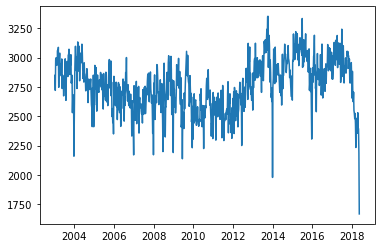

In [60]:
plt.plot(data['larceny_count'])

**Normalizing**
1. Normalizing Input features

In [80]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))

scaled_input = sc_in.fit_transform(data[['population', 'unemployment']])
scaled_input =pd.DataFrame(scaled_input)

X= scaled_input
X.rename(columns={0:'population', 1:'unemployment'}, inplace=True)

In [81]:
X

,population,unemployment
0,0.020708,0.491081
1,0.020708,0.491081
2,0.020708,0.491081
3,0.020708,0.467294
4,0.020708,0.467294
...,...,...
796,1.000000,0.028091
797,1.000000,0.028091
798,1.000000,0.028091
799,1.000000,0.000000


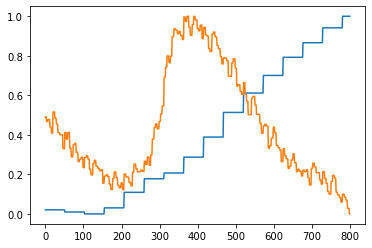

In [82]:
plt.plot(X)

2. Scaling output features

In [84]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(data[['actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output
y.rename(columns={0:'larceny_count'}, inplace=True)
y

,larceny_count
0,0.158661
1,0.633188
2,0.540029
3,0.729985
4,0.742358
...,...
796,0.274381
797,0.401747
798,0.304221
799,0.302766


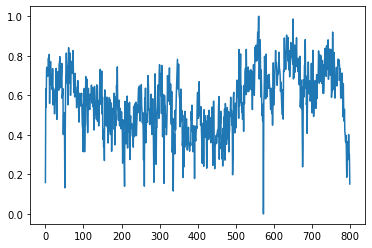

In [85]:
plt.plot(y)

**Train Test Split**

In [89]:
#size of train and test sets
train_size=int(len(data) *0.7)
test_size = int(len(data)) - train_size
print('train size', train_size,'test size', test_size)

train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()
train_X

train size 560 test size 241


,population,unemployment
0,0.020708,0.491081
1,0.020708,0.491081
2,0.020708,0.491081
3,0.020708,0.467294
4,0.020708,0.467294
...,...,...
555,0.611501,0.503451
556,0.611501,0.503451
557,0.611501,0.503451
558,0.611501,0.503451


In [90]:
test_X

,population,unemployment
560,0.611501,0.503886
561,0.611501,0.503886
562,0.611501,0.503886
563,0.611501,0.503886
564,0.611501,0.458527
...,...,...
796,1.000000,0.028091
797,1.000000,0.028091
798,1.000000,0.028091
799,1.000000,0.000000


In [ ]:
#Use dates for train-test split
#train = data[data.next_monday < datetime.date(2017,1,1)]
#test = data[data.next_monday >= datetime.date(2017,1,1)]
#Use ratio for train-test split

**Seasonal Decomposition**

In [91]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

Additive seasonality

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


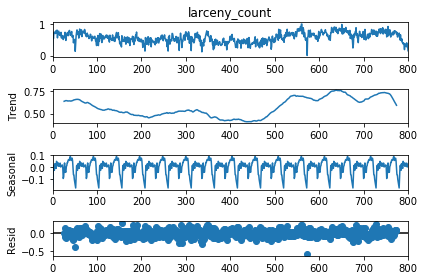

In [97]:
seas_d = seasonal_decompose(y['larceny_count'],model='add',freq=52);
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

**Test for Stationary Trend**

In [98]:
def test_adf(series, title=''):
    dfout = {}
    dftest = adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1] <= 0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [99]:
y_test=y['larceny_count'][:train_size].dropna()
test_adf(y_test, " Larceny Count")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary  Larceny Count


In [ ]:
test_adf(y_test.diff(), “ Stock Price”)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
plt.plot(train['larceny_count'])

In [ ]:
test = test[test.next_monday!=datetime.date(2018,5,21)]
plt.plot(test['larceny_count'])

In [ ]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [ ]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [ ]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [ ]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [ ]:
data = train.larceny_count
print(data.shape)
# data split
n_test = 12
# model configs
cfg_list = sarima_configs(seasonal=[0,6,12])
#print(cfg_list)
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

In [ ]:
population = pd.read_csv("../input/covars/population.csv")
unemployment = pd.read_csv("../input/covars/unemployment.csv")

In [ ]:
population.head(5)

In [ ]:
plt.plot(unemployment["Unemployment_rate"])

In [ ]:
unemployment.head(5)

In [ ]:
train.tail(5)

In [ ]:
train["population"] = [int(population[population.Year == d.year]['Population']) for d in train["next_monday"]]
train["unemployment"] = [float(unemployment[(unemployment.Year == d.year) & (unemployment.Month == d.month)]['Unemployment_rate']) for d in train["next_monday"]]

In [ ]:
train.head(10)

In [ ]:
#import packages
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Variables
endog = train['larceny_count']
exog = train[['population','unemployment']]

# Fit the model
mod = SARIMAX(endog, exog, order=(0,0,1), seasonal_order=(1,0,2,12))
res = mod.fit(disp=False)
print(res.summary())

In [ ]:
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [ ]:
predict.predicted_mean.plot(ax=ax, style='r--', label='One-step-ahead forecast')

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Larceny/Theft Incidents', xlabel='Date', ylabel='Number of Incidents')

train['larceny_count'].plot(ax=ax, style='o', label='Observed')
predict.predicted_mean.plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - endog
predict_error.plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.copy()
ci.iloc[:,0] -= endog
ci.iloc[:,1] -= endog
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)